## 1. Environment Setup

In [45]:
import sys
import os
import json
import warnings
from pathlib import Path

# CRITICAL FIX: Prevent OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown

# SEM / CFA
import semopy
from semopy import Model

# Reliability calculations
import pingouin as pg

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

POPULATION = 'professional'

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Population: {POPULATION.upper()}")
print(f"✓ semopy version: {semopy.__version__}")

✓ Libraries loaded
✓ Random seed: 67
✓ Population: PROFESSIONAL
✓ semopy version: 2.3.11


## 2. Load Data and ALL EFA Solutions

In [46]:
# Load holdout sample for CFA validation
df_holdout = pd.read_csv('data/AIRS_holdout.csv')

# Load ALL EFA solutions from Phase 1
with open('data/all_efa_solutions.json', 'r') as f:
    all_efa_solutions = json.load(f)

# Load item metadata
with open('../data/airs_28item_complete.json', 'r') as f:
    item_metadata = json.load(f)

metadata = item_metadata['metadata']
predictor_items = item_metadata['predictor_items']

print(f"📊 {POPULATION.upper()} Sample CFA Validation")
print(f"   Holdout N: {len(df_holdout)}")
print(f"\nEFA Solutions to Test:")
print(f"   Solutions: {all_efa_solutions['solutions_tested']}")
print(f"   PA recommended: {all_efa_solutions['pa_recommended']}-factor")
print(f"   Kaiser criterion: {all_efa_solutions['kaiser_recommended']}-factor")

📊 PROFESSIONAL Sample CFA Validation
   Holdout N: 146

EFA Solutions to Test:
   Solutions: [2, 3, 4, 5, 6]
   PA recommended: 2-factor
   Kaiser criterion: 3-factor


In [61]:
# Display EFA solution summary
efa_summary = []
for sol_key, sol_data in all_efa_solutions['solutions'].items():
    efa_summary.append({
        'Solution': sol_key,
        'Factors': sol_data['n_factors'],
        'Variance %': f"{sol_data['variance_explained']:.1f}",
        'Good Loadings': f"{sol_data['good_loadings']}/24",
        'Good Communalities': f"{sol_data['good_communalities']}/24"
    })

efa_summary_df = pd.DataFrame(efa_summary)
print("EFA Solutions Summary from Phase 1:")
display(efa_summary_df)

EFA Solutions Summary from Phase 1:


,Solution,Factors,Variance %,Good Loadings,Good Communalities
0,2F,2,59.6,23/24,23/24
1,3F,3,57.7,23/24,22/24
2,4F,4,59.2,22/24,20/24
3,5F,5,59.6,21/24,21/24
4,6F,6,60.2,21/24,20/24


## 3. Define CFA Helper Functions

In [62]:
def build_cfa_syntax(items_per_factor, factor_prefix='F'):
    """Build semopy model syntax from item assignments."""
    model_lines = []
    factors = sorted(items_per_factor.keys())
    
    for factor in factors:
        items = items_per_factor[factor]
        if len(items) > 0:
            items_str = ' + '.join(items)
            model_lines.append(f"{factor} =~ {items_str}")
    
    if len(factors) >= 2:
        for i, f1 in enumerate(factors):
            for f2 in factors[i+1:]:
                model_lines.append(f"{f1} ~~ {f2}")
    
    return '\n'.join(model_lines)


def fit_cfa_model(df, model_syntax):
    """Fit CFA model and return fit statistics."""
    try:
        model = Model(model_syntax)
        model.fit(df)
        fit_stats = semopy.calc_stats(model)
        return model, fit_stats, True
    except Exception as e:
        print(f"   ⚠️ Model fitting error: {e}")
        return None, None, False


def extract_fit_indices(fit_stats):
    """Extract key fit indices from semopy output."""
    indices = {
        'chi2': fit_stats.loc['Value', 'chi2'] if 'chi2' in fit_stats.columns else None,
        'df': fit_stats.loc['Value', 'DoF'] if 'DoF' in fit_stats.columns else None,
        'CFI': fit_stats.loc['Value', 'CFI'] if 'CFI' in fit_stats.columns else None,
        'TLI': fit_stats.loc['Value', 'TLI'] if 'TLI' in fit_stats.columns else None,
        'RMSEA': fit_stats.loc['Value', 'RMSEA'] if 'RMSEA' in fit_stats.columns else None,
        'AIC': fit_stats.loc['Value', 'AIC'] if 'AIC' in fit_stats.columns else None,
        'BIC': fit_stats.loc['Value', 'BIC'] if 'BIC' in fit_stats.columns else None
    }
    return indices


def assess_fit(indices):
    """Assess model fit against standard thresholds."""
    cfi = indices.get('CFI')
    tli = indices.get('TLI')
    rmsea = indices.get('RMSEA')
    
    return {
        'CFI_status': '✓ Good' if cfi and cfi >= 0.95 else ('⚠️ Acceptable' if cfi and cfi >= 0.90 else '❌ Poor'),
        'TLI_status': '✓ Good' if tli and tli >= 0.95 else ('⚠️ Acceptable' if tli and tli >= 0.90 else '❌ Poor'),
        'RMSEA_status': '✓ Good' if rmsea and rmsea <= 0.06 else ('⚠️ Acceptable' if rmsea and rmsea <= 0.08 else '❌ Poor'),
        'overall': 'Acceptable' if (cfi and cfi >= 0.90 and rmsea and rmsea <= 0.08) else 'Poor'
    }


def calculate_reliability(df, items_per_factor, model):
    """Calculate reliability metrics for each factor."""
    params = model.inspect(std_est=True)
    loadings_df = params[params['op'] == '~'].copy()
    
    if 'Est. Std' in loadings_df.columns:
        loading_col = 'Est. Std'
    else:
        loading_col = 'Estimate'
    
    results = []
    for factor, items in items_per_factor.items():
        if len(items) < 2:
            continue
            
        factor_loadings = loadings_df[loadings_df['rval'] == factor][loading_col].values
        
        if len(factor_loadings) == 0:
            continue
        
        # Composite Reliability
        sum_loadings = sum(factor_loadings)
        sum_loadings_sq = sum_loadings ** 2
        sum_error_var = sum(1 - l**2 for l in factor_loadings)
        cr = sum_loadings_sq / (sum_loadings_sq + sum_error_var)
        
        # AVE
        ave = np.mean([l**2 for l in factor_loadings])
        
        # Cronbach's alpha
        try:
            alpha_result = pg.cronbach_alpha(df[items])
            alpha = alpha_result[0]
        except:
            alpha = np.nan
        
        results.append({
            'Factor': factor,
            'N_Items': len(items),
            'Cronbach_Alpha': alpha,
            'CR': cr,
            'AVE': ave,
            'CR_Status': '✓' if cr >= 0.70 else '⚠️',
            'AVE_Status': '✓' if ave >= 0.50 else '⚠️'
        })
    
    return pd.DataFrame(results)

print("✓ CFA helper functions defined")

✓ CFA helper functions defined


## 4. Fit CFA Models for ALL EFA Solutions

In [49]:
# ═══════════════════════════════════════════════════════════════════════════════
# FIT CFA FOR ALL EFA SOLUTIONS
# ═══════════════════════════════════════════════════════════════════════════════

cfa_results = {}
n_holdout = len(df_holdout)

print(f"Fitting CFA models on holdout sample (N = {n_holdout})")
print("=" * 70)

for sol_key, sol_data in all_efa_solutions['solutions'].items():
    n_factors = sol_data['n_factors']
    items_per_factor = sol_data['items_per_factor']
    
    print(f"\n{sol_key} ({n_factors}-factor model):")
    
    # Get all items for this solution
    all_items = []
    for items in items_per_factor.values():
        all_items.extend(items)
    
    # Create analysis dataframe
    df_cfa = df_holdout[all_items].copy()
    
    # Build and fit model
    model_syntax = build_cfa_syntax(items_per_factor)
    model, fit_stats, success = fit_cfa_model(df_cfa, model_syntax)
    
    if success:
        indices = extract_fit_indices(fit_stats)
        assessment = assess_fit(indices)
        reliability_df = calculate_reliability(df_cfa, items_per_factor, model)
        
        cfa_results[sol_key] = {
            'n_factors': n_factors,
            'model': model,
            'fit_stats': fit_stats,
            'indices': indices,
            'assessment': assessment,
            'reliability': reliability_df,
            'items_per_factor': items_per_factor,
            'df_cfa': df_cfa,
            'model_syntax': model_syntax
        }
        
        print(f"   CFI: {indices['CFI']:.3f} {assessment['CFI_status']}")
        print(f"   TLI: {indices['TLI']:.3f} {assessment['TLI_status']}")
        print(f"   RMSEA: {indices['RMSEA']:.3f} {assessment['RMSEA_status']}")
        print(f"   AIC: {indices['AIC']:.1f}")
        print(f"   BIC: {indices['BIC']:.1f}")
    else:
        cfa_results[sol_key] = {'success': False, 'n_factors': n_factors}
        print(f"   ❌ Model did not converge")

print("\n" + "=" * 70)
print(f"✓ Fitted {len([r for r in cfa_results.values() if r.get('model')])} of {len(all_efa_solutions['solutions'])} models")

Fitting CFA models on holdout sample (N = 146)

2F (2-factor model):
   CFI: 0.866 ❌ Poor
   TLI: 0.853 ❌ Poor
   RMSEA: 0.102 ❌ Poor
   AIC: 89.4
   BIC: 235.6

3F (3-factor model):
   CFI: 0.877 ❌ Poor
   TLI: 0.863 ❌ Poor
   RMSEA: 0.098 ❌ Poor
   AIC: 93.8
   BIC: 246.0

4F (4-factor model):
   CFI: 0.883 ❌ Poor
   TLI: 0.869 ❌ Poor
   RMSEA: 0.096 ❌ Poor
   AIC: 100.1
   BIC: 261.2

5F (5-factor model):


   CFI: 0.888 ❌ Poor
   TLI: 0.872 ❌ Poor
   RMSEA: 0.095 ❌ Poor
   AIC: 108.3
   BIC: 281.4

6F (6-factor model):
   CFI: 0.889 ❌ Poor
   TLI: 0.871 ❌ Poor
   RMSEA: 0.096 ❌ Poor
   AIC: 118.4
   BIC: 306.4

✓ Fitted 5 of 5 models


## 5. Model Comparison

In [50]:
# ═══════════════════════════════════════════════════════════════════════════════
# MODEL COMPARISON TABLE
# ═══════════════════════════════════════════════════════════════════════════════

comparison_data = []

for sol_key, result in cfa_results.items():
    if result.get('model'):
        indices = result['indices']
        assessment = result['assessment']
        
        comparison_data.append({
            'Model': sol_key,
            'Factors': result['n_factors'],
            'χ²': f"{indices['chi2']:.1f}",
            'df': int(indices['df']) if indices['df'] else 'NA',
            'CFI': f"{indices['CFI']:.3f}",
            'TLI': f"{indices['TLI']:.3f}",
            'RMSEA': f"{indices['RMSEA']:.3f}",
            'AIC': f"{indices['AIC']:.1f}",
            'BIC': f"{indices['BIC']:.1f}",
            'Fit': assessment['overall']
        })

comparison_df = pd.DataFrame(comparison_data)

print("CFA Model Comparison - All EFA Solutions")
print("=" * 90)
print("\nFit Criteria: CFI/TLI ≥ 0.90 acceptable, ≥ 0.95 good; RMSEA ≤ 0.08 acceptable, ≤ 0.06 good")
print("Lower AIC/BIC indicates better model (for same data)\n")
display(comparison_df)

CFA Model Comparison - All EFA Solutions

Fit Criteria: CFI/TLI ≥ 0.90 acceptable, ≥ 0.95 good; RMSEA ≤ 0.08 acceptable, ≤ 0.06 good
Lower AIC/BIC indicates better model (for same data)



,Model,Factors,χ²,df,CFI,TLI,RMSEA,AIC,BIC,Fit
0,2F,2,630.8,251,0.866,0.853,0.102,89.4,235.6,Poor
1,3F,3,599.2,249,0.877,0.863,0.098,93.8,246.0,Poor
2,4F,4,577.6,246,0.883,0.869,0.096,100.1,261.2,Poor
3,5F,5,560.9,242,0.888,0.872,0.095,108.3,281.4,Poor
4,6F,6,551.3,237,0.889,0.871,0.096,118.4,306.4,Poor


In [63]:
# ═══════════════════════════════════════════════════════════════════════════════
# IDENTIFY BEST MODEL
# ═══════════════════════════════════════════════════════════════════════════════

model_scores = []

for sol_key, result in cfa_results.items():
    if result.get('model'):
        indices = result['indices']
        cfi_score = indices['CFI'] if indices['CFI'] else 0
        rmsea_penalty = indices['RMSEA'] if indices['RMSEA'] else 1
        score = cfi_score - rmsea_penalty
        
        model_scores.append({
            'model': sol_key,
            'score': score,
            'CFI': cfi_score,
            'RMSEA': rmsea_penalty,
            'AIC': indices['AIC'],
            'acceptable': indices['CFI'] >= 0.90 and indices['RMSEA'] <= 0.08
        })

model_scores = sorted(model_scores, key=lambda x: x['score'], reverse=True)

print("Model Ranking (by CFI - RMSEA score):")
print("=" * 60)
for i, m in enumerate(model_scores, 1):
    status = "✓" if m['acceptable'] else "✗"
    print(f"{i}. {m['model']}: Score={m['score']:.3f} (CFI={m['CFI']:.3f}, RMSEA={m['RMSEA']:.3f}) {status}")

best_model_key = model_scores[0]['model']
best_result = cfa_results[best_model_key]

print(f"\n★ Best-fitting model: {best_model_key}")

acceptable_models = [m for m in model_scores if m['acceptable']]
if acceptable_models:
    print(f"\n✓ {len(acceptable_models)} model(s) meet acceptable fit criteria")
else:
    print(f"\n⚠️ No models meet acceptable fit criteria (CFI ≥ 0.90, RMSEA ≤ 0.08)")

Model Ranking (by CFI - RMSEA score):
1. 6F: Score=0.794 (CFI=0.889, RMSEA=0.096) ✗
2. 5F: Score=0.792 (CFI=0.888, RMSEA=0.095) ✗
3. 4F: Score=0.787 (CFI=0.883, RMSEA=0.096) ✗
4. 3F: Score=0.778 (CFI=0.877, RMSEA=0.098) ✗
5. 2F: Score=0.764 (CFI=0.866, RMSEA=0.102) ✗

★ Best-fitting model: 6F

⚠️ No models meet acceptable fit criteria (CFI ≥ 0.90, RMSEA ≤ 0.08)


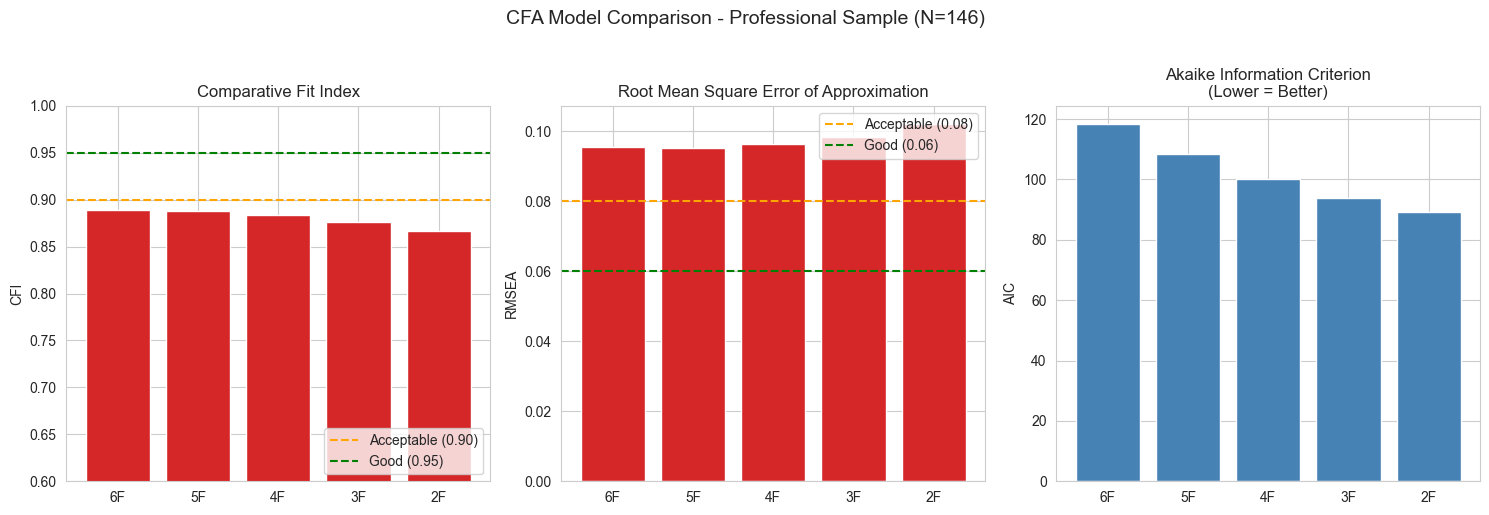

✓ Model comparison chart saved to plots/02_cfa_model_comparison.png


In [52]:
# ═══════════════════════════════════════════════════════════════════════════════
# FIT INDICES VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [m['model'] for m in model_scores]
cfis = [m['CFI'] for m in model_scores]
rmseas = [m['RMSEA'] for m in model_scores]
aics = [m['AIC'] for m in model_scores]

# CFI
colors_cfi = ['#2ca02c' if c >= 0.95 else '#ff7f0e' if c >= 0.90 else '#d62728' for c in cfis]
axes[0].bar(models, cfis, color=colors_cfi)
axes[0].axhline(y=0.90, color='orange', linestyle='--', label='Acceptable (0.90)')
axes[0].axhline(y=0.95, color='green', linestyle='--', label='Good (0.95)')
axes[0].set_ylabel('CFI')
axes[0].set_title('Comparative Fit Index')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0.6, 1.0)

# RMSEA
colors_rmsea = ['#2ca02c' if r <= 0.06 else '#ff7f0e' if r <= 0.08 else '#d62728' for r in rmseas]
axes[1].bar(models, rmseas, color=colors_rmsea)
axes[1].axhline(y=0.08, color='orange', linestyle='--', label='Acceptable (0.08)')
axes[1].axhline(y=0.06, color='green', linestyle='--', label='Good (0.06)')
axes[1].set_ylabel('RMSEA')
axes[1].set_title('Root Mean Square Error of Approximation')
axes[1].legend(loc='upper right')

# AIC
axes[2].bar(models, aics, color='steelblue')
axes[2].set_ylabel('AIC')
axes[2].set_title('Akaike Information Criterion\n(Lower = Better)')

plt.suptitle(f'CFA Model Comparison - {POPULATION.title()} Sample (N={n_holdout})', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/02_cfa_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Model comparison chart saved to plots/02_cfa_model_comparison.png")

## 6. Best Model Details

In [53]:
# ═══════════════════════════════════════════════════════════════════════════════
# BEST MODEL: FACTOR LOADINGS
# ═══════════════════════════════════════════════════════════════════════════════

print(f"Best Model Details: {best_model_key}")
print("=" * 70)

best_model = best_result['model']
params = best_model.inspect(std_est=True)

loadings_df = params[params['op'] == '~'].copy()

if 'Est. Std' in loadings_df.columns:
    loadings_df = loadings_df[['rval', 'lval', 'Est. Std', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']
else:
    loadings_df = loadings_df[['rval', 'lval', 'Estimate', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']

loadings_df['Construct'] = loadings_df['Item'].apply(
    lambda x: metadata[x]['construct_abbr'] if x in metadata else 'Unknown'
)

def get_sig(p):
    if isinstance(p, str) or pd.isna(p):
        return '(fixed)'
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

loadings_df['Sig'] = loadings_df['p'].apply(get_sig)

print(f"\nFactor Loadings (Standardized):")
display(loadings_df.round(4))

Best Model Details: 6F

Factor Loadings (Standardized):


,Factor,Item,Loading,SE,z,p,Construct,Sig
0,F1,PE1,0.8121,-,-,-,PE,(fixed)
1,F1,PE2,0.8481,0.083663,12.490236,0.0,PE,***
2,F1,SI1,0.7819,0.090097,11.086352,0.0,SI,***
3,F1,HM1,0.8730,0.083543,13.063359,0.0,HM,***
4,F1,HM2,0.8929,0.080097,13.54142,0.0,HM,***
5,F1,PV1,0.8844,0.081912,13.335036,0.0,PV,***
6,F1,PV2,0.8803,0.077235,13.238473,0.0,PV,***
7,F1,HB1,0.8221,0.096232,11.920213,0.0,HB,***
8,F1,HB2,0.8266,0.093135,12.016521,0.0,HB,***
9,F1,VO1,0.8380,0.093206,12.266602,0.0,VO,***


In [54]:
# ═══════════════════════════════════════════════════════════════════════════════
# BEST MODEL: RELIABILITY
# ═══════════════════════════════════════════════════════════════════════════════

reliability_df = best_result['reliability']

print(f"\nReliability Assessment - {best_model_key}:")
print("=" * 70)
print("Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70")
display(reliability_df.round(4))


Reliability Assessment - 6F:
Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70


,Factor,N_Items,Cronbach_Alpha,CR,AVE,CR_Status,AVE_Status
0,F1,12,0.9601,0.9610,0.6760,✓,✓
1,F2,3,0.8347,0.8438,0.6445,✓,✓
2,F4,3,0.8314,0.8361,0.6297,✓,✓
3,F3,4,0.6659,0.6612,0.3824,⚠️,⚠️


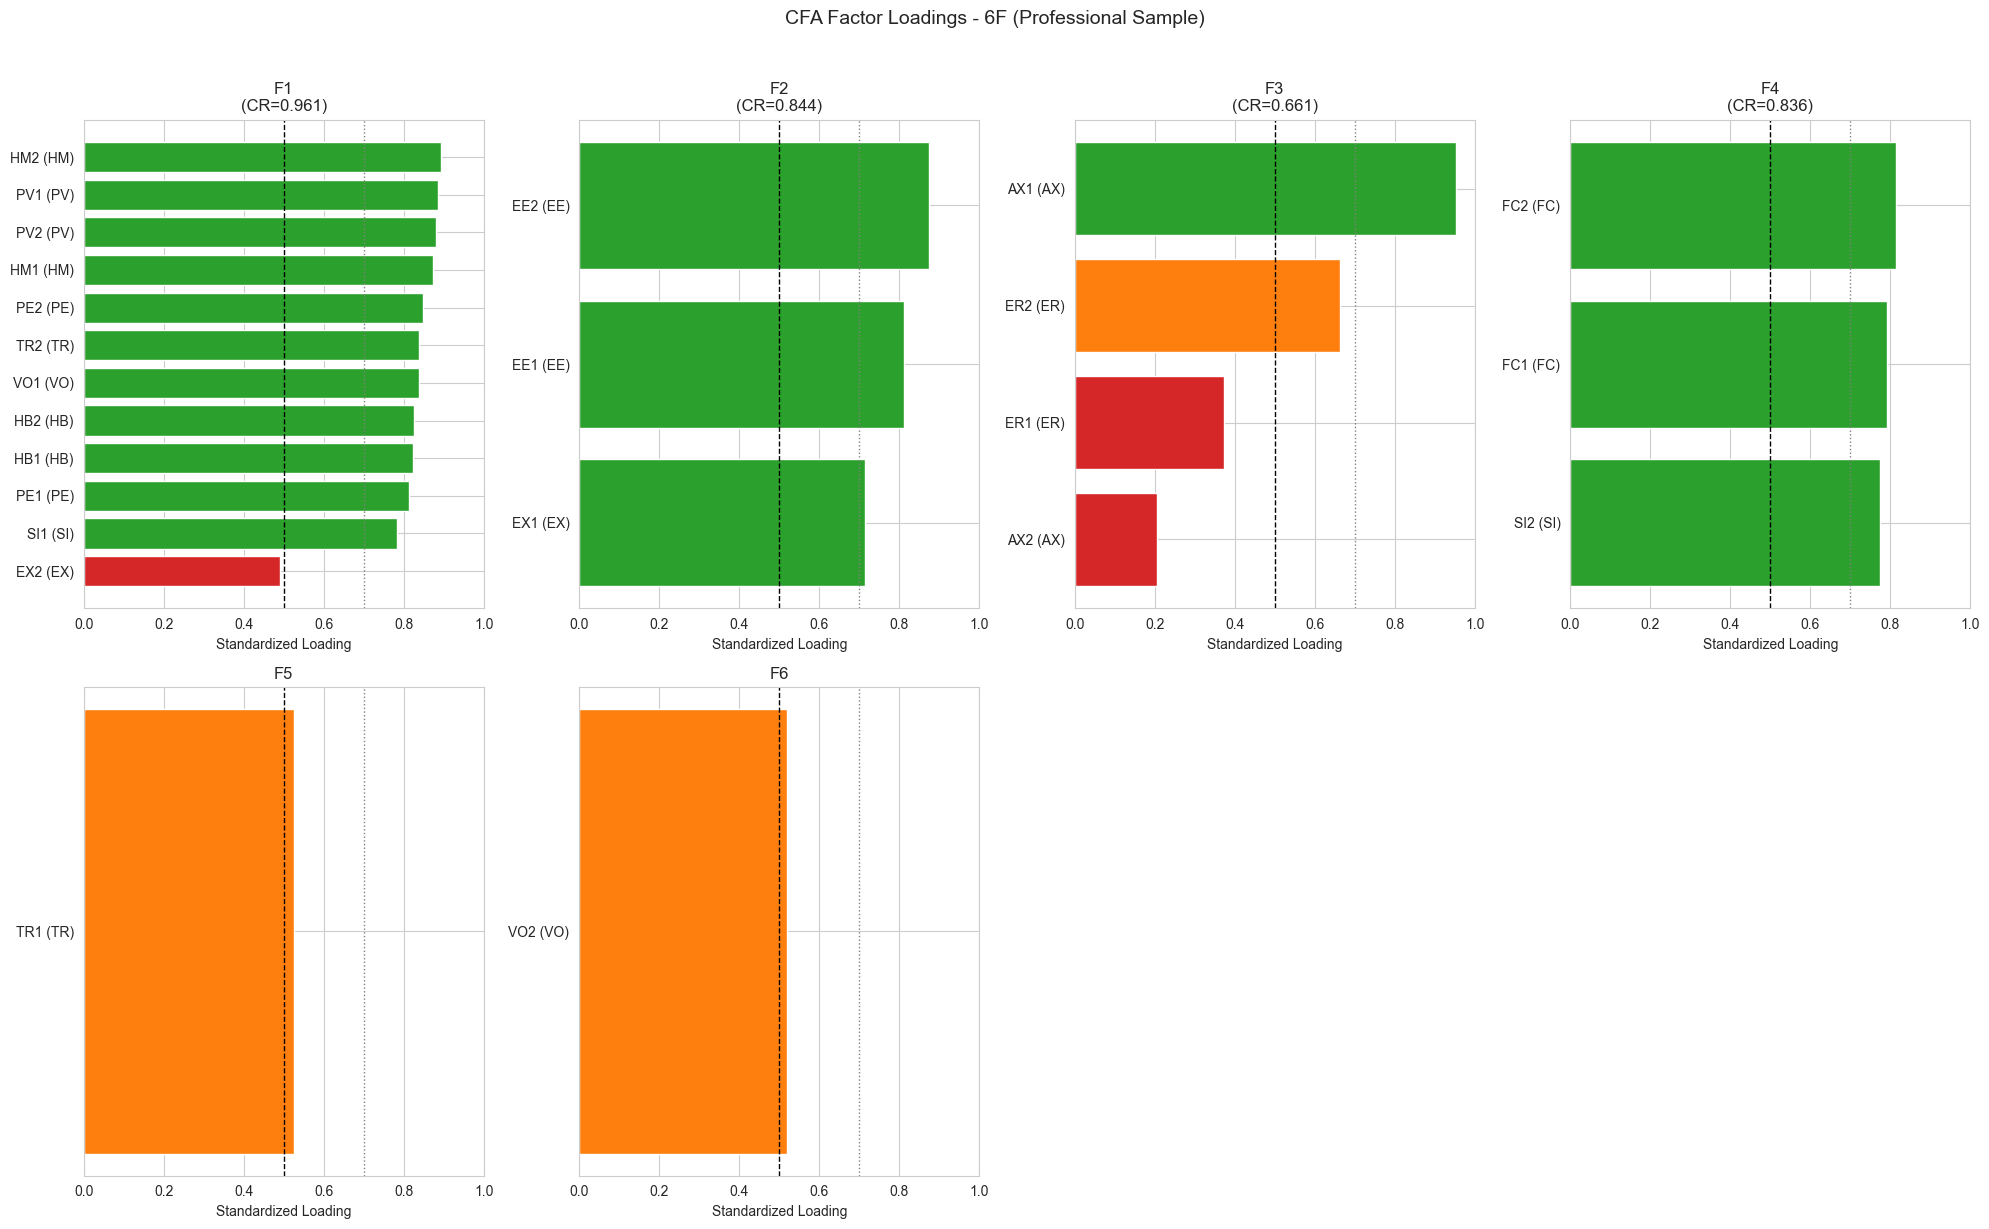

✓ Loading chart saved to plots/02_cfa_loadings.png


In [55]:
# ═══════════════════════════════════════════════════════════════════════════════
# FACTOR LOADING VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

n_factors = best_result['n_factors']
n_cols = min(n_factors, 4)
n_rows = (n_factors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
if n_factors == 1:
    axes = [axes]
elif n_rows == 1:
    axes = list(axes)
else:
    axes = axes.flatten()

for idx, factor in enumerate(sorted(loadings_df['Factor'].unique())):
    if idx >= len(axes):
        break
    ax = axes[idx]
    factor_data = loadings_df[loadings_df['Factor'] == factor].sort_values('Loading', ascending=True)
    
    colors = ['#2ca02c' if l >= 0.7 else '#ff7f0e' if l >= 0.5 else '#d62728' 
              for l in factor_data['Loading']]
    
    ax.barh(range(len(factor_data)), factor_data['Loading'], color=colors)
    ax.set_yticks(range(len(factor_data)))
    ax.set_yticklabels([f"{row['Item']} ({row['Construct']})" for _, row in factor_data.iterrows()])
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=0.7, color='gray', linestyle=':', linewidth=1)
    ax.set_xlabel('Standardized Loading')
    
    factor_rel = reliability_df[reliability_df['Factor'] == factor]
    if len(factor_rel) > 0:
        cr = factor_rel['CR'].values[0]
        ax.set_title(f'{factor}\n(CR={cr:.3f})')
    else:
        ax.set_title(f'{factor}')
    ax.set_xlim(0, 1)

for idx in range(n_factors, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'CFA Factor Loadings - {best_model_key} ({POPULATION.title()} Sample)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/02_cfa_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Loading chart saved to plots/02_cfa_loadings.png")

## 7. Export Results

In [56]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXPORT RESULTS
# ═══════════════════════════════════════════════════════════════════════════════

comparison_df.to_csv('tables/02_cfa_model_comparison.csv', index=False)
loadings_df.to_csv('tables/02_cfa_loadings.csv', index=False)
reliability_df.to_csv('tables/02_cfa_reliability.csv', index=False)

cfa_export = {
    'population': POPULATION,
    'n_holdout': n_holdout,
    'models_tested': list(cfa_results.keys()),
    'best_model': best_model_key,
    'model_comparison': [
        {
            'model': r['model'],
            'CFI': r['CFI'],
            'RMSEA': r['RMSEA'],
            'AIC': r['AIC'],
            'acceptable': r['acceptable']
        }
        for r in model_scores
    ],
    'best_model_details': {
        'n_factors': best_result['n_factors'],
        'fit_indices': best_result['indices'],
        'items_per_factor': best_result['items_per_factor'],
        'reliability': reliability_df.to_dict('records')
    }
}

with open('data/cfa_results.json', 'w') as f:
    json.dump(cfa_export, f, indent=2, default=str)

print("✓ Results exported:")
print("   - tables/02_cfa_model_comparison.csv")
print("   - tables/02_cfa_loadings.csv")
print("   - tables/02_cfa_reliability.csv")
print("   - data/cfa_results.json")

✓ Results exported:
   - tables/02_cfa_model_comparison.csv
   - tables/02_cfa_loadings.csv
   - tables/02_cfa_reliability.csv
   - data/cfa_results.json


## 8. Summary

In [57]:
# ═══════════════════════════════════════════════════════════════════════════════
# CFA SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

best_indices = best_result['indices']
best_assessment = best_result['assessment']

print("=" * 60)
print(f"CFA SUMMARY - {POPULATION.upper()} SAMPLE")
print("=" * 60)

print(f"\nSample: N = {n_holdout} (holdout)")
print(f"Models tested: {len(cfa_results)} ({', '.join(cfa_results.keys())})")

print(f"\nBest Model: {best_model_key}")
print(f"   CFI: {best_indices['CFI']:.4f} {best_assessment['CFI_status']}")
print(f"   TLI: {best_indices['TLI']:.4f} {best_assessment['TLI_status']}")
print(f"   RMSEA: {best_indices['RMSEA']:.4f} {best_assessment['RMSEA_status']}")
print(f"   AIC: {best_indices['AIC']:.1f}")
print(f"   BIC: {best_indices['BIC']:.1f}")

print(f"\nReliability:")
for _, row in reliability_df.iterrows():
    print(f"   {row['Factor']}: CR={row['CR']:.3f} {row['CR_Status']}, AVE={row['AVE']:.3f} {row['AVE_Status']}, α={row['Cronbach_Alpha']:.3f}")

good_fit = best_indices['CFI'] >= 0.90 and best_indices['RMSEA'] <= 0.08
good_reliability = all(reliability_df['CR'] >= 0.70)
good_ave = all(reliability_df['AVE'] >= 0.50)

print(f"\nOverall Assessment:")
print(f"   Model Fit: {'✓ Acceptable' if good_fit else '⚠️ Needs improvement'}")
print(f"   Reliability: {'✓ Good' if good_reliability else '⚠️ Issues detected'}")
print(f"   Convergent Validity (AVE): {'✓ Good' if good_ave else '⚠️ Issues detected'}")

CFA SUMMARY - PROFESSIONAL SAMPLE

Sample: N = 146 (holdout)
Models tested: 5 (2F, 3F, 4F, 5F, 6F)

Best Model: 6F
   CFI: 0.8894 ❌ Poor
   TLI: 0.8712 ❌ Poor
   RMSEA: 0.0956 ❌ Poor
   AIC: 118.4
   BIC: 306.4

Reliability:
   F1: CR=0.961 ✓, AVE=0.676 ✓, α=0.960
   F2: CR=0.844 ✓, AVE=0.645 ✓, α=0.835
   F4: CR=0.836 ✓, AVE=0.630 ✓, α=0.831
   F3: CR=0.661 ⚠️, AVE=0.382 ⚠️, α=0.666

Overall Assessment:
   Model Fit: ⚠️ Needs improvement
   Reliability: ⚠️ Issues detected
   Convergent Validity (AVE): ⚠️ Issues detected


## 9. APA Method Summary

In [58]:
chi2_str = f"{best_indices['chi2']:.2f}" if best_indices['chi2'] else 'NA'
df_str = f"{int(best_indices['df'])}" if best_indices['df'] else 'NA'
cfi_str = f"{best_indices['CFI']:.3f}" if best_indices['CFI'] else 'NA'
tli_str = f"{best_indices['TLI']:.3f}" if best_indices['TLI'] else 'NA'
rmsea_str = f"{best_indices['RMSEA']:.3f}" if best_indices['RMSEA'] else 'NA'

fit_desc = 'acceptable' if good_fit else 'marginal'
rel_desc = 'All factors demonstrated acceptable reliability (CR ≥ .70).' if good_reliability else 'Some factors showed reliability concerns (CR < .70).'
ave_desc = 'All factors met the .50 threshold for AVE.' if good_ave else 'Some factors showed AVE below the .50 threshold, suggesting convergent validity concerns.'

n_models = len(cfa_results)
models_str = ', '.join([f"{r['n_factors']}-factor" for sol_key, r in cfa_results.items() if r.get('model')])

apa_summary = f"""
### Method Summary (APA Format)

**Confirmatory Factor Analysis - {POPULATION.title()} Sample**

Confirmatory factor analysis (CFA) was conducted on the independent holdout sample 
(*N* = {n_holdout}) to validate the factor structures identified in exploratory factor analysis. 
All {n_models} candidate models ({models_str}) from EFA were tested using maximum likelihood 
estimation in semopy (Python).

Models were compared using standard fit indices. The {best_model_key} demonstrated 
the best relative fit among the tested models: χ²({df_str}) = {chi2_str}, 
CFI = {cfi_str}, TLI = {tli_str}, RMSEA = {rmsea_str}. This model showed {fit_desc} 
fit to the data based on conventional thresholds (CFI/TLI ≥ .90, RMSEA ≤ .08; Hu & Bentler, 1999).

Reliability was assessed using composite reliability (CR) and Cronbach's alpha. 
{rel_desc} Convergent validity was evaluated using average variance extracted (AVE). 
{ave_desc}

These results will be compared with CFA findings from the Full and Academic samples 
to evaluate measurement equivalence across populations.
"""

display(Markdown(apa_summary))


### Method Summary (APA Format)

**Confirmatory Factor Analysis - Professional Sample**

Confirmatory factor analysis (CFA) was conducted on the independent holdout sample 
(*N* = 146) to validate the factor structures identified in exploratory factor analysis. 
All 5 candidate models (2-factor, 3-factor, 4-factor, 5-factor, 6-factor) from EFA were tested using maximum likelihood 
estimation in semopy (Python).

Models were compared using standard fit indices. The 6F demonstrated 
the best relative fit among the tested models: χ²(237) = 551.27, 
CFI = 0.889, TLI = 0.871, RMSEA = 0.096. This model showed marginal 
fit to the data based on conventional thresholds (CFI/TLI ≥ .90, RMSEA ≤ .08; Hu & Bentler, 1999).

Reliability was assessed using composite reliability (CR) and Cronbach's alpha. 
Some factors showed reliability concerns (CR < .70). Convergent validity was evaluated using average variance extracted (AVE). 
Some factors showed AVE below the .50 threshold, suggesting convergent validity concerns.

These results will be compared with CFA findings from the Full and Academic samples 
to evaluate measurement equivalence across populations.
